# Text-mining-applied-project

Búsqueda y Recuperación de Información 
Se busca construir un sistema de búsqueda y recuperación de información que sea capaz de identificar información relevante para el usuario en grandes volúmenes de información (Documentos Científicos). Este proceso se lleva a cabo mediante la construcción de un Bag of Words, método utilizado para representar la información de los documentos en palabras.

In [1]:
import glob # libreria para extraer la ruta de los archivos
import re # libreria para manejos de expresiones regulares
import collections #### para poder contar los hash
import pandas as pd # libreria para manejo de bases datos
import numpy as np # libreria para manejo de vectores y arreglos
import json #libreria para leer los metadatos guardados como un json
import operator #Libreria para organizar de mayor a menor
import matplotlib.pyplot as plt #libreria para graficas
from nltk.corpus import stopwords, wordnet # importa las stop words y las palabras del ingles
from nltk.stem.porter import PorterStemmer # metodo para stemming
from nltk.stem.lancaster import LancasterStemmer # metodo para stemming
from nltk.stem import WordNetLemmatizer # metodo para lematizar
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize

### Creación del Bag of Words
Para la creación del Bag of Words se construye una lista de todos los documentos científicos almacenados en formato .txt, luego se extrae el texto de cada uno de los documentos y se realiza una limpieza para cada una de las palabras en los diferentes documentos. Entre los procesos de limpieza están:
* Tokenización: Es el proceso de separar un texto en cadenas separadas por espacios o signos de puntuación.
* Eliminar Stopwords: Eliminar palabras como artículos, conjunciones y preposiciones.
* Stemming: Eliminar los sufijos de la palabra usando PorterStemmer de la librería NLTK.
* Lematización: Proceso de convertir la palabra en la raíz
* Otros: Limpieza de palabras de 1 carácter y palabras con más de tres letras consecutivas


In [2]:
#Read Files
#files_txt = glob.glob("/opt/datasets/mcda-pi1-20191/papers-txt/*.txt")
files_txt = glob.glob("C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\*") #Computer Andres

# instanciar la clase para lematizar
wordnet_lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() # instancia una forma de stemming
# llamamos al diccionario de stop words en ingles
sw = stopwords.words("english")

#leer Meta Datos
meta_data = open("xml_parser/metadata_dict.txt","r",encoding='utf-8').read()
meta_data = json.loads(meta_data)

In [3]:
def tokenizer(texto):
    texto  = texto.lower()
    texto  = re.sub("""(?:(?:https?|ftp):\/\/|\b(?:[a-z\d]+\.))(?:(?:[^\s()<>]+|\((?:[^\s()<>]+|(?:\([^\s()<>]+\)))?\))+(?:\((?:[^\s()<>]+|(?:\(?:[^\s()<>]+\)))?\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))?""",' ',texto) # Eliminar las URL
    texto  = re.sub('-|\u2212|\u2012|\u2013|\u2014|\u2015',' ',texto)#\(([^)]+)\)|\[([^)]+)\]|
    texto  = re.sub('((\w*)?xyz|xyx|aba|abc|aab|zz|xx|yy|ijk(\w*)?)', ' ',texto)
    texto  = re.sub('[a-zA-Z0-9.?{}]+@\w+\.\w+.\w*',' ',texto) 
    texto  = re.sub('(á|à|ä)','a',texto)
    texto  = re.sub('(é|è|ë)','e',texto)
    texto  = re.sub('(í|ì|ï)','i',texto)
    texto  = re.sub('(ó|ò|ö)','o',texto)
    texto  = re.sub('(ú|ù|ü)','u',texto)
    #texto = re.sub('[^A-Za-z0-9]+','',texto)
    tokens = word_tokenize(texto)
    tokens = [re.sub('[^A-Za-z0-9]+','',word) for word in tokens if not bool(re.search(r'(.)\1{2,}', word))]
    return tokens

def limpiar_tokens(tokens, is_metadata = False):
    if is_metadata:
        #wordnet_lemmatizer.lemmatize(stemmer.stem(w.lower()), pos="v")
        return [wordnet_lemmatizer.lemmatize(stemmer.stem(w.lower()), pos="v") for w in tokens if (len(w)>1) and (w not in sw) and w.isalpha()]       
    else: 
        return [wordnet_lemmatizer.lemmatize(stemmer.stem(w.lower()), pos="v") for w in tokens if (len(w)>1) and (len(w)<15) and (w not in sw) and w.isalpha() ] 

In [4]:
documentos_text = list()
documentos      = list()
for file in files_txt:
    #Leer Informacion
    input_file = open(file,"r",encoding='utf-8')
    texto = input_file.read()
    meta_data_info = meta_data[file.replace("\\","/").split("/")[-1].replace(".txt","")]
    
    #tokenizacion
    tokens = tokenizer(texto)
    tokens_metada = tokenizer(meta_data_info)
    #mirar cant
    
    # aplica lematizacion, stemming, elimina de stop words y aplica reglas lógicas para reducir la cantidad de tokens
    tokens = limpiar_tokens(tokens)
    tokens_metada = limpiar_tokens(tokens, is_metadata = True)
    documentos_text.append(' '.join(tokens + tokens_metada))
    documentos.append(file)

## Para la creación del Bag of Words

### Usamos la librería de machine learning sklearn para construir nuestro diccionario de palabras 

* CountVectorizer: Nos permite contar el numero de palabras que ocurren en cada uno de los documentos tf
* TfidfVectorizer: Calcula el tf  * idf donde idf = $log(\frac{1+n}{1+df})+1$, cada fila del vector está en norma 2

#### Referencias:
1. [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)
2. [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer)


In [5]:
count_vectorizer = CountVectorizer(analyzer = "word",tokenizer = word_tokenize,    \
                             preprocessor = None, \
                             stop_words = sw,   \
                             lowercase = True,  \
                             max_features = None)


bow_tf = count_vectorizer.fit_transform(documentos_text)

C:\Users\Andres\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [6]:
bow_tf.shape #doc, words

(980, 75026)

In [7]:
tfidf_vectorizer=TfidfVectorizer(analyzer = "word",tokenizer = word_tokenize,    \
                             preprocessor = None, \
                             stop_words = sw,   \
                             lowercase = True,  \
                             max_features = None)
 
# just send in all your docs here
bow_tfidf = tfidf_vectorizer.fit_transform(documentos_text)

In [8]:
bow_tfidf.shape #doc, words

(980, 75026)

### Convertimos el resultado de CountVectorizer y TfidfVectorizer a un DataFrame de Pandas
Este proceso fue necesario porque estos objetos utilizan las listas nativas de python y se hizo muy ineficiente al momento de construir el inverted index, ya que por ser una lista de listas este tenia que buscar sobre todo el conjunto de datos. Con pandas utilizando la función loc, podíamos buscar la palabra o retornando solo el tf que necesitábamos haciendo una búsqueda dentro de nuestro bag of words.


In [9]:
bow_tfidf_df = pd.DataFrame(bow_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names())
bow_tfidf_df.head()
#bow_tfidf_df.loc[bow_tfidf_df['aa'] > 0].head()

,aa,aaa,aab,aabb,aachen,aad,aadm,aaecc,aaem,aag,...,zytnicki,zyuban,zyvoloski,zyy,zz,zzf,zzi,zzn,zzpe,zzr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.076363,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [10]:
bow_tf_df = pd.DataFrame(bow_tf.toarray(), columns=count_vectorizer.get_feature_names())
bow_tf_df.head()
#bow_tf_df.loc[bow_tf_df['aa'] > 0].head()

,aa,aaa,aab,aabb,aachen,aad,aadm,aaecc,aaem,aag,...,zytnicki,zyuban,zyvoloski,zyy,zz,zzf,zzi,zzn,zzpe,zzr
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,12,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Inverted Index
Es la estructura de datos más utilizada para la búsqueda en los sistemas de búsqueda y recuperación de información.
Para la construcción de esta estructura de datos utilizamos los diccionarios de python para realizar una indexación por palabra y adicionar una lista de tuplas, donde cada una tiene la información del documento, el tfidf de la palabra, el tf y el tamaño en palabras del bag of words para el documento.

##### Ejemplo:

| word        | doc     | tfidf           | tf      | doc_length    |
|-------------|---------|-----------------|---------|---------------|
| biology     | [1,2,7] | [0.01,0.04,0.1] | [3,4,2] | [340,600,428] |
| computer    | [2,3]   | [0.023,0.012]   | [5,18]  | [250,1118]    |
| mathematics | [1]     | [0.1]           | [8]     | [128]         |

In [11]:
documentos_length = [sum(words) for words in bow_tf.toarray()]

In [12]:
inverted_index = {}
for word in bow_tfidf_df.columns:
    inverted_index[word] = []
    for row in bow_tf_df.loc[bow_tf_df[word] > 0].index:
        doc = documentos[row]
        tf = bow_tf_df[word][row]
        tfidf = bow_tfidf_df[word][row]
        doc_length = documentos_length[row]
        inverted_index[word].append( (doc, tfidf, tf, doc_length) )

### Query
Para realizar la búsqueda realizamos tres aproximaciones, ya que queríamos ir comparando los resultados poco a poco con el experto que utilizamos metapy, que es una librería en python utilizada para el procesamiento de texto.

Utilizamos el Okapi BM25 que es una función de ranking que nos permite calificar las búsquedas para la Recuperación de información y asignar la relevancia a cada uno de los documentos en un buscador que tiene las palabras que el usuario desea buscar.


$score(D,Q) = \sum_{i=1}^{n}IDF(q_{i}) * \frac{f(q_{i}, D) * (k_{1} + 1)}{f(q_{i}, D) + k_{1} * (1-b+b*\frac{|D|}{avgdl})} $

$k_{1}=1.2, b=0.75$

In [ ]:
def query_inverted_text(term):
    resultado = []
    for doc, tfidf, tf, doc_length in inverted_index[term]:
        resultado.append(doc)
    return resultado
len(query_inverted_text('biolog'))
#inverted_index['characterist']

In [ ]:
def query_inverted_text(terms=[]):
    resultado = {}
    for term in terms:
        if term in inverted_index:
            for doc, tfidf, tf, doc_length  in inverted_index[term]:
                if doc in resultado:
                    resultado[doc] += tfidf
                else:
                    resultado[doc] = tfidf
    return resultado
query = query_inverted_text(['biolog'])
sorted_x = sorted(query.items(), key=operator.itemgetter(1), reverse=True)[:10]
sorted_x
#inverted_index['characterist']

In [13]:
def query_inverted_text_bm25(query, k1=1.2, b=0.75):
    resultado = {}
    query_tokens = tokenizer(query)
    query_tokens = limpiar_tokens(query_tokens)
    avgdl = np.mean(documentos_length)
    for term in query_tokens:
        doc_query_conriene = len(inverted_index[term])
        query_idf = np.log((len(documentos_length) - doc_query_conriene + 0.5) / (doc_query_conriene + 0.5))
        for doc, tfidf, tf, doc_length  in inverted_index[term]:
            upper = tf *  (k1 + 1)
            below = tf + k1*(1 - b + (b * (doc_length / avgdl)))
            if doc in resultado:
                resultado[doc] += query_idf * (upper / below)
            else:
                resultado[doc] = query_idf * (upper / below)
    return resultado
query = query_inverted_text_bm25("biology")
sorted_x = sorted(query.items(), key=operator.itemgetter(1), reverse=True)[:10]
sorted_x

[('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1505.02348.txt',
  3.768314727950289),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1506.00366.txt',
  3.7637786485414715),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1503.07759.txt',
  3.756089211970236),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1412.0291.txt',
  3.735804771153706),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1510.06482.txt',
  3.7266678998679543),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1505.05193.txt',
  3.718464365988264),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1504.06320.txt',
  3.6878202598958922),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1403.1080.txt',
  3.662337278308276),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1210.2246.txt',
  3.651134864714912),
 

## MeTa
Utilizaremos una librería de Python con herramienta para procesar texto y la utilizaremos para construir un índice invertido y generar un ranker que nos ayude a comparar los documentos recuperados por nuestra consulta

In [14]:
import metapy

In [15]:
inv_idx = metapy.index.make_inverted_index("config.toml")

In [16]:
inv_idx.num_docs()

980

In [17]:
ranker = metapy.index.OkapiBM25()

In [18]:
query_meta = metapy.index.Document()
query_meta.content("statistics")

In [19]:
top_docs = ranker.score(inv_idx, query_meta, num_results=10)

In [20]:
top_docs

[(736, 1.7807728052139282),
 (658, 1.7700905799865723),
 (399, 1.7677022218704224),
 (16, 1.7660155296325684),
 (827, 1.7563282251358032),
 (677, 1.752448320388794),
 (805, 1.7521823644638062),
 (657, 1.7474273443222046),
 (34, 1.7392793893814087),
 (366, 1.7389888763427734)]

In [21]:
def meta_top_docs(top_docs):
    person = []
    for num, (d_id, d) in enumerate(top_docs):   
        val_1 = inv_idx.label(d_id)
        person.append((val_1, d))
    return person
person = meta_top_docs(top_docs)
person

[('../data/papers_own_impl/1507.01279.txt', 1.7807728052139282),
 ('../data/papers_own_impl/1505.02214.txt', 1.7700905799865723),
 ('../data/papers_own_impl/1407.4908.txt', 1.7677022218704224),
 ('../data/papers_own_impl/0910.2912.txt', 1.7660155296325684),
 ('../data/papers_own_impl/1509.02900.txt', 1.7563282251358032),
 ('../data/papers_own_impl/1505.06770.txt', 1.752448320388794),
 ('../data/papers_own_impl/1508.04720.txt', 1.7521823644638062),
 ('../data/papers_own_impl/1505.02213.txt', 1.7474273443222046),
 ('../data/papers_own_impl/1006.1029.txt', 1.7392793893814087),
 ('../data/papers_own_impl/1405.4472.txt', 1.7389888763427734)]

In [22]:
query2 = query_inverted_text_bm25("statistics")
sorted_x = sorted(query2.items(), key=operator.itemgetter(1), reverse=True)[:10]
sorted_x

[('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1507.01279.txt',
  0.09825573553568295),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1407.4908.txt',
  0.09806042404570327),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1505.02214.txt',
  0.09804792445599794),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\0910.2912.txt',
  0.09796606325375239),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1311.4821.txt',
  0.09785149876151872),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1508.04720.txt',
  0.09780310838375153),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1109.2984.txt',
  0.0977690786916122),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1505.02213.txt',
  0.09773773971357527),
 ('C:\\Users\\Andres\\Desktop\\MAESTRIA\\SEMESTRE_I\\texto\\papers-txt\\1509.02900.txt',
  0.09771381

In [23]:
#person[0][0].split("/")[-1]
y_true = [i[0].split('/')[-1] for i in person]
y_pred = [j[0].split('\\')[-1] for j in sorted_x]

In [24]:
from sklearn.metrics import confusion_matrix

# matriz de confusion multiclase
confusion_matrix(y_true, y_pred)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [25]:
y_trueb = [1 if x in y_true else 0 for x in y_true]
print(y_trueb)
print('------------')
y_predb = [1 if x in y_true else 0 for x in y_pred]
print(y_predb)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
------------
[1, 1, 1, 1, 0, 1, 0, 1, 1, 1]


In [26]:
confusion_matrix(y_true=y_trueb, y_pred=y_predb).ravel()

array([0, 0, 2, 8], dtype=int64)

In [27]:
tn, fp, fn, tp = confusion_matrix(y_true=y_trueb, y_pred=y_predb).ravel()
(tn, fp, fn, tp)

(0, 0, 2, 8)

(0.0, 1.0)

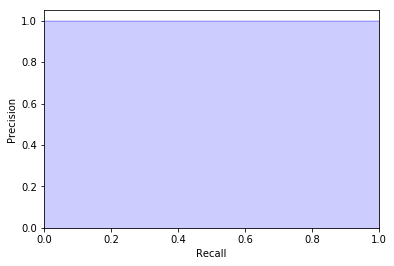

In [28]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from inspect import signature

precision, recall, _ = precision_recall_curve(y_trueb, y_predb)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])

In [29]:
p = tp/(tp+fp)
print('Precision ',round(p,2))
print('--------------------')
r = tp/(tp+fn)
print('Recall ',round(r,2))

Precision  1.0
--------------------
Recall  0.8


In [30]:
def calificar_query(querys):
    ranker = metapy.index.OkapiBM25()
    resultado = {}
    for query in querys:
        query_meta = metapy.index.Document()
        query_meta.content(query)
        top_docs = ranker.score(inv_idx, query_meta, num_results=10)
        expert = meta_top_docs(top_docs)
        len_expert = len(expert)
        
        buscador = query_inverted_text_bm25(query)
        buscador = sorted(buscador.items(), key=operator.itemgetter(1), reverse=True)[:len_expert]
        
        #buscador += [0 for i in range(len(expert) - len(buscador))]
        y_true = [i[0].split('/')[-1] for i in expert]
        y_pred = [j[0].split('\\')[-1] for j in buscador]
        #boolean form of y_true and y_pred
        y_trueb = [1 if x in y_true else 0 for x in y_true]
        y_predb = [1 if x in y_true else 0 for x in y_pred]
        
        conf_matrix = confusion_matrix(y_trueb, y_predb).ravel()
        if len(conf_matrix) > 1:
            tn, fp, fn, tp = conf_matrix
        else:
            tn, fp, fn = 0,0,0
            tp = conf_matrix[0]
        p = tp/(tp+fp) #print('Precision ',round(p,2))
        r = tp/(tp+fn) #print('Recall ',round(r,2))
        resultado[query] = (round(p,2), round(r,2))
    return resultado
resultado_compare = calificar_query(["biology", "activity", "machine learning",
                 "machine", "math", "magazine", "mahalanobis distance",
                 "kruskal algorithm", "mathematician", "norm", "matrix norm",
                 "sparse", "stochastic", "news", "random forest", "logistic regression", "statistics",
                 "root", "python", "inverse matrix", "clustering", "michael jordan", "Carl Friedrich Gauss",
                 "europe", "rank","Algebra", "quick sort", "education", 
                 "Chinese rice","security","cryptography and network security", "bank", "radiology",
                 "google", "page ranker", "twitter", "facebook","germany", "colombia", "linux", "text",
                 "text mining", "wikipedia", "population", "city", "country", "master and slave",
                 "Polynomial", "Isaac Newton", "ibm", "red hat", "Structured Query Language", 
                 "programming language sql", "software", "filesystem", "albert einstein", "android",
                 "gpu", "cpu", "keyboard", "hardware", "internet", "intel","aws emr", "magic spell", 
                 "genetic algorithm", "valuable gem","general electric","world clock","neural networks",
                 "big data", "bytes","tv","business analytics","mental disease", "black market", "integrator project",
                 "likelihood", "text volume", "amazon", "Soft Condensed Matter", "Software Engineering", "Sound", 
                 "Spectral Theory", "Statistical Finance", "Statistical Mechanics"])
resultado_compare

C:\Users\Andres\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in longlong_scalars


{'biology': (1.0, 1.0),
 'activity': (1.0, 0.8),
 'machine learning': (1.0, 0.8),
 'machine': (1.0, 1.0),
 'math': (1.0, 0.7),
 'magazine': (1.0, 0.9),
 'mahalanobis distance': (1.0, 1.0),
 'kruskal algorithm': (1.0, 0.8),
 'mathematician': (1.0, 0.9),
 'norm': (1.0, 0.8),
 'matrix norm': (1.0, 0.2),
 'sparse': (1.0, 0.9),
 'stochastic': (1.0, 0.9),
 'news': (1.0, 0.7),
 'random forest': (1.0, 0.1),
 'logistic regression': (1.0, 0.9),
 'statistics': (1.0, 0.8),
 'root': (1.0, 1.0),
 'python': (1.0, 1.0),
 'inverse matrix': (1.0, 0.3),
 'clustering': (1.0, 0.9),
 'michael jordan': (1.0, 0.8),
 'Carl Friedrich Gauss': (1.0, 0.7),
 'europe': (1.0, 0.9),
 'rank': (1.0, 0.9),
 'Algebra': (1.0, 0.9),
 'quick sort': (1.0, 0.5),
 'education': (1.0, 0.9),
 'Chinese rice': (1.0, 0.6),
 'security': (1.0, 1.0),
 'cryptography and network security': (1.0, 0.6),
 'bank': (1.0, 0.9),
 'radiology': (1.0, 1.0),
 'google': (1.0, 0.9),
 'page ranker': (1.0, 0.3),
 'twitter': (1.0, 0.9),
 'facebook': (1.0

In [ ]:
#print(count_vectorizer.get_feature_names())

In [31]:
querys_result = []
values_result = []
for key, values in resultado_compare.items():
    querys_result.append(key)
    values_result.append(values[1])

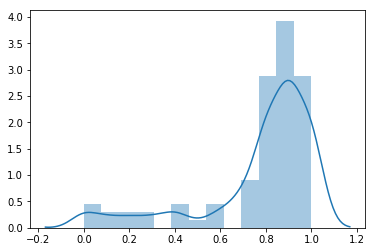

In [32]:
import seaborn as sns

sns.distplot(values_result)

In [33]:
np.percentile(values_result, 20)

0.7

# Procesamiento de Metadatos

In [49]:
meta_datos = open("xml_parser/metadata_dict.txt","r",encoding='utf-8').read()
meta_datos = json.loads(meta_datos)

In [50]:
meta_datos['0704.3504']

"Smooth R\\'enyi Entropy of Ergodic Quantum Information Sources,We prove that the average smooth Renyi entropy rate will approach the entropy\nrate of a stationary, ergodic information source, which is equal to the Shannon\nentropy rate for a classical information source and the von Neumann entropy\nrate for a quantum information source. Comment: 5 pages, no figures, ISIT 2007"

In [55]:
documentos_meta_datos = list()
for file in files_txt:
    #Leer Informacion
    meta_datos_info = meta_data[file.replace("\\","/").split("/")[-1].replace(".txt","")]
    
    #tokenizacion
    tokens_meta_datos = tokenizer(meta_datos_info)
    
    # aplica lematizacion, stemming, elimina de stop words y aplica reglas lógicas para reducir la cantidad de tokens
    tokens_meta_datos = limpiar_tokens(tokens_meta_datos, is_metadata = True)
    documentos_meta_datos.append(' '.join(tokens_meta_datos))

In [60]:
df_metadatos = pd.DataFrame(documentos_meta_datos,columns=['content'])

In [61]:
df_metadatos.head()

,content
0,smooth renyi entropi ergod quantum inform sour...
1,analyz design process experi anita gener tutor...
2,colour imag segment vector valu allen cahn pha...
3,unequ error protect inform theoret perspect bo...
4,hit time quantum versu random walk magniez fre...


In [ ]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.mllib.linalg import Vector, Vectors
from pyspark.mllib.clustering import LDA, LDAModel
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, CountVectorizer
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA, BisectingKMeans
from pyspark.sql.functions import monotonically_increasing_id
import re
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession

from pyspark.sql.types import StringType

sc = SparkContext('local', "topic-detection") 
spark = SparkSession(sc)